## Generating Pokemon with DCGAN

Training a GAN model to learn to genrate fake pokemons from a set of training images. 
[https://www.kaggle.com/kvpratama/pokemon-images-dataset/data](https://www.kaggle.com/kvpratama/pokemon-images-dataset/data) 

To run the notebook, download the files and put them in the `./data/POKE/train/pokemon` folder.



In [1]:
# Import the required libraries
import torch
import torch.nn as nn 
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
# Same network structure as the CelebA experiment
from celeba_models import Generator, Discriminator
from util import weight_init

sns.set_style('darkgrid')

In [2]:
# Hyperparameters for the training procedure
batch_size = 200
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

# Transformations applied to the initial images
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation([-90, 90]), # randomly apply rotation to images
    torchvision.transforms.Resize(64),
    torchvision.transforms.CenterCrop(64),
    torchvision.transforms.RandomHorizontalFlip(), # randomly flip the images on the y-axis
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the images from the `data/CELEBA` folder
dataset = torchvision.datasets.ImageFolder('./data/POKE', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

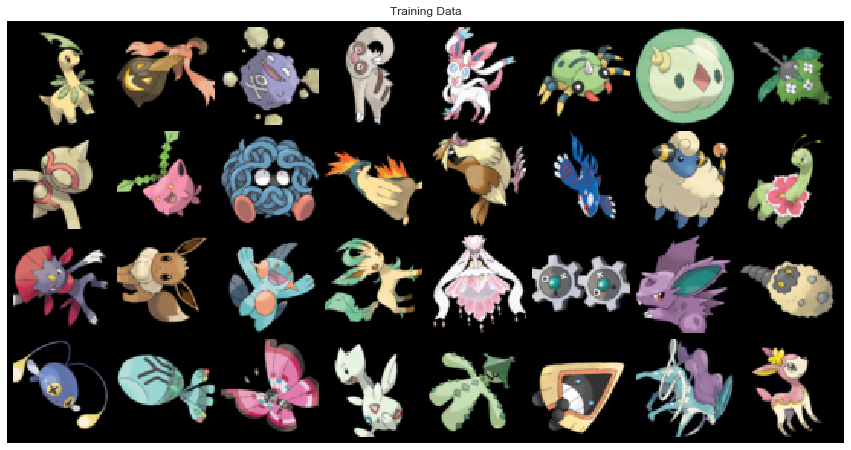

In [3]:
# Visualize some of the training data
plt.figure(figsize=(15, 8))
data, _ = next(iter(dataloader))

# Remove normalization from images and restore original images for correct visualization
data = data * 0.5 + 0.5

grid = torchvision.utils.make_grid(data[:32], nrow=8, padding=4)
plt.imshow(grid.permute(1, 2, 0))
plt.title('Training Data')
plt.axis('off')
plt.show()

In [4]:
latent_size = 100 # size of z vector
generator = Generator().to(device)
generator.apply(weight_init)
discriminator = Discriminator().to(device)
discriminator.apply(weight_init)

criterion = nn.BCELoss()
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=7e-4, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=3e-4, betas=(0.5, 0.999))

print(generator)
print(discriminator)

Generator(
  (deconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (tanh): Tanh()
)
Discriminator(
  (dropout): Dropout2d(p=0.2, inplace=False)
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm1): B

In [5]:
# Save loss and accuracy for plot
list_discriminator_fake = []
list_discriminator_real = []
list_generator = []

# Helper function to generate and save images ever so often: 
def save_images(file_name):
    noise = torch.randn((32, latent_size)).to(device)
    x = generator(noise)
    
    # Remove normalization from images and restore original images for correct visualization
    x = x * 0.5 + 0.5

    plt.figure(figsize=(15, 8))
    grid = torchvision.utils.make_grid(x, nrow=8, padding=4)
    plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
    plt.axis('off')
    plt.savefig('./images/' + file_name)
    plt.close()

In [6]:
epochs = 2000
label_smooth = 0.1
real_labels, fake_labels = 1.0 - label_smooth, 0.0

y_real = torch.full((batch_size, 1), real_labels).to(device)
y_fake = torch.full((batch_size, 1), fake_labels).to(device)

discriminator_steps = 2
generator_steps = 1

for e in range(epochs):
    for (idx, data) in enumerate(dataloader, 0):

        running_discriminator_loss = 0
    
        for _ in range(discriminator_steps):
            discriminator_optimizer.zero_grad()

            # Train discriminator on real training data
            x, _ = data
            x = x.to(device)

            y_pred = discriminator(x)
            error_real = criterion(y_pred, y_real)
            error_real.backward()

            # Train discriminator on fake training data
            noise = torch.randn((batch_size, latent_size)).to(device)
            x_fake = generator(noise)
            y_pred = discriminator(x_fake.detach())
            error_fake = criterion(y_pred, y_fake)
            error_fake.backward()

            discriminator_optimizer.step()

            running_discriminator_loss += error_real.item() + error_fake.item()
       
        # TODO: consider all iterations
        list_discriminator_fake.append(error_fake.item())
        list_discriminator_real.append(error_real.item())

        running_generator_loss = 0
        for _ in range(generator_steps):

            # Train generator to generate fake data
            generator_optimizer.zero_grad()
            noise = torch.randn((batch_size, latent_size)).to(device)
            x_fake = generator(noise)
            y_pred = discriminator(x_fake)
            generator_loss = criterion(y_pred, y_real)
            generator_loss.backward()

            generator_optimizer.step()

            running_generator_loss += generator_loss.item()      

        list_generator.append(running_generator_loss)

        if idx % 2 == 0:
            print("Epoch {}, Iteration {}/{} \t Loss Gen. {:.2f}, Loss Dic. {:.2f}".format(
                e, idx+1, len(dataset) // batch_size, 
                running_generator_loss, running_discriminator_loss
            ))

        if idx % 50 == 0:
            save_images(f"pokemon/iteration_{e}_{idx}.png")

poch 1830, Iteration 3/4 	 Loss Gen. 4.29, Loss Dic. 0.86
Epoch 1831, Iteration 1/4 	 Loss Gen. 4.34, Loss Dic. 0.87
Epoch 1831, Iteration 3/4 	 Loss Gen. 4.23, Loss Dic. 0.79
Epoch 1832, Iteration 1/4 	 Loss Gen. 4.02, Loss Dic. 0.76
Epoch 1832, Iteration 3/4 	 Loss Gen. 4.12, Loss Dic. 0.91
Epoch 1833, Iteration 1/4 	 Loss Gen. 4.38, Loss Dic. 0.89
Epoch 1833, Iteration 3/4 	 Loss Gen. 4.11, Loss Dic. 0.87
Epoch 1834, Iteration 1/4 	 Loss Gen. 4.18, Loss Dic. 0.90
Epoch 1834, Iteration 3/4 	 Loss Gen. 4.48, Loss Dic. 1.03
Epoch 1835, Iteration 1/4 	 Loss Gen. 4.28, Loss Dic. 0.81
Epoch 1835, Iteration 3/4 	 Loss Gen. 4.28, Loss Dic. 0.83
Epoch 1836, Iteration 1/4 	 Loss Gen. 4.06, Loss Dic. 0.76
Epoch 1836, Iteration 3/4 	 Loss Gen. 4.19, Loss Dic. 0.88
Epoch 1837, Iteration 1/4 	 Loss Gen. 4.34, Loss Dic. 0.77
Epoch 1837, Iteration 3/4 	 Loss Gen. 4.43, Loss Dic. 0.82
Epoch 1838, Iteration 1/4 	 Loss Gen. 4.15, Loss Dic. 0.82
Epoch 1838, Iteration 3/4 	 Loss Gen. 4.20, Loss Dic. 0.8

The loss over the duration of the training. Figure on the left-hand side shows the generator and discriminator loss. The figure on the right-hand side shows the discriminator loss split into the loss on the fake- and real training samples.


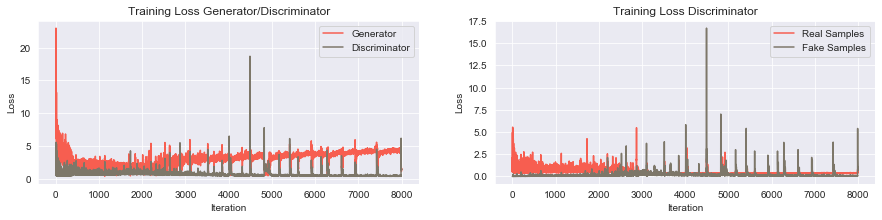

In [7]:
# Plot the training loss
plt.figure(figsize=(15, 3))

plt.subplot(121)
plt.title("Training Loss Generator/Discriminator")
plt.plot(list_generator, color='#f75e50')
plt.plot(np.array(list_discriminator_real) + np.array(list_discriminator_fake), color='#7d7769')
plt.xlabel("Iteration")
plt.legend(['Generator', 'Discriminator'])
plt.ylabel("Loss")

plt.subplot(122)
plt.title('Training Loss Discriminator')
plt.plot(list_discriminator_real, color='#f75e50')
plt.plot(list_discriminator_fake, color='#7d7769')
plt.xlabel("Iteration")
plt.legend(['Real Samples', 'Fake Samples'])
plt.ylabel("Loss")
plt.show()

In [13]:
# Save the model
model_weights = {
    'generator': generator.state_dict,
    'discriminator': discriminator.state_dict
}
torch.save(model_weights, 'models/poke_gan.pt')

C:\Program Files\Python36\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Program Files\Python36\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvTranspose2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Program Files\Python36\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Program Files\Python36\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked

### Testing

Testing the learned generator model to generate new pokemon learned from the dataset. 

As you can see, the results are more or less a meaningless mess and similar to other PokeGAN approaches if found on GitHub.  
At least some of them have a nice shape and color which could be used as inspo when designing new ones. 


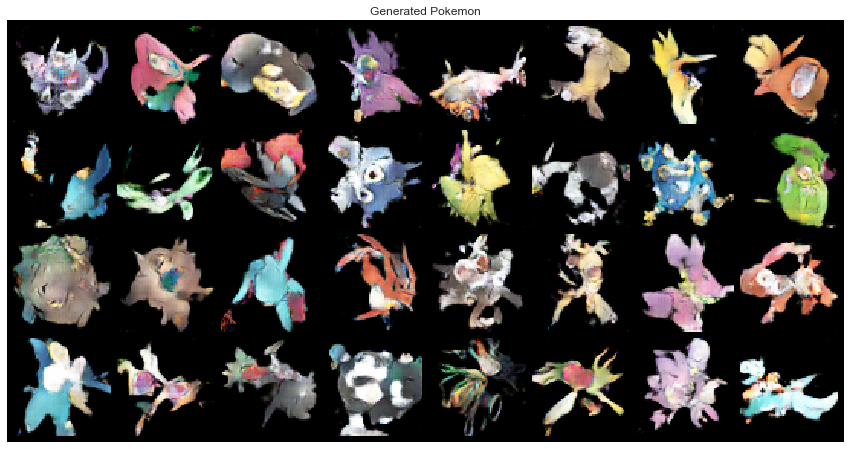

In [14]:
noise = torch.randn((32, latent_size)).to(device)
x = generator(noise) * 0.5 + 0.5

plt.figure(figsize=(15, 8))
grid = torchvision.utils.make_grid(x, nrow=8, padding=4)
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.title('Generated Pokemon')
plt.axis('off')
plt.show()